In [13]:
### Library Import Initialization
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# Function Import
import sys
sys.path.append('/Users/mburley/MonteCarlo/MonteCarlo')
from MC_Functions import import_stock_data, daily_returns

[*********************100%%**********************]  1 of 1 completed


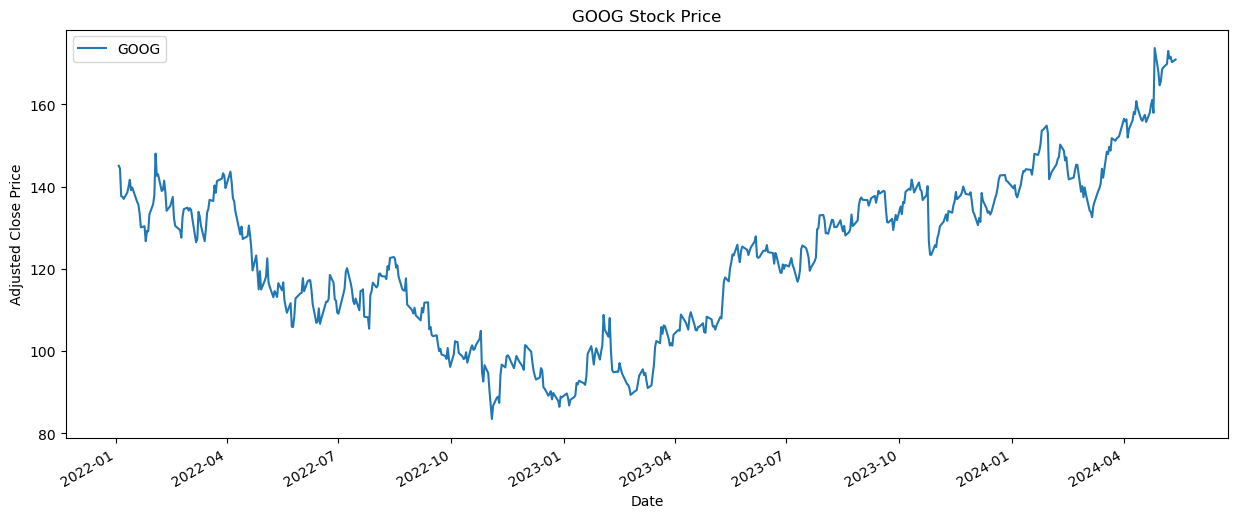

In [12]:
### Function to Import Stock Tickers
# Import Stock Data
tickers = 'GOOG'
start_date = '2022-01-01'
stock_data = import_stock_data(tickers, start_date)

# Plot
stock_data.plot(figsize=(15, 6))
plt.title(f'{tickers} Stock Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

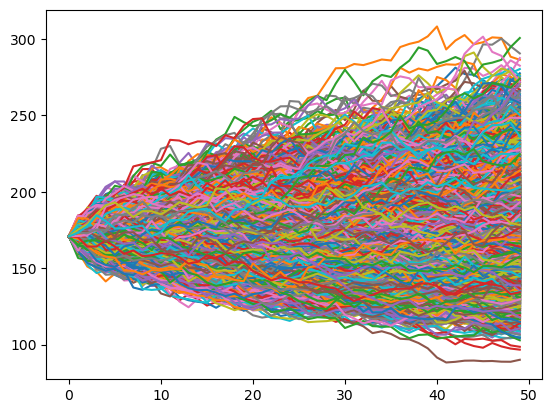

In [18]:
### Function Calls to Compute Daily Log Returns (Brownian Motion) and Generate Paths 
# Compute Daily Returns
days = 50           # Projecting out 50 days
trials = 10000      # Total trials
daily_rets = daily_returns(stock_data, days, trials, return_type = 'log')
#daily_rets

# Generate Price Paths
def price_paths(data, daily_returns):
    # Initialize array with the same shape as daily_returns but filled with zeros
    price_paths = np.zeros_like(daily_returns)
    # Set initial value of price paths to the last value in the stock prices df
    price_paths[0] = data.iloc[-1]

    # Loop over the price paths array and compute the price at each time step (t) based on the previous price (price_paths[t-1]) and the 
    # corresponding daily return (daily_returns[t])
    for t in range(1, days):
        price_paths[t] = price_paths[t-1]*daily_returns[t]

    return price_paths

# Call and Plot each of the 10000 price paths over the 50 day span
paths = price_paths(stock_data, daily_rets)
plt.plot(paths)
plt.show
